In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from torchinfo import summary         
import numpy as np
import torchvision.transforms as tf
import transformers                    
from tensorboardX import SummaryWriter 
from pkg_resources import packaging    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from openTSNE import TSNE              
import pandas as pd
import seaborn as sns

from tqdm import tqdm
import random
import re
import time
import math
import decoder_models

import gc
import sys
from pympler import tracker
tr = tracker.SummaryTracker()
from torchvision import transforms

seed = 2023
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.benchmark = False  
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda')
cpu = torch.device('cpu')

In [2]:
duplicate_channel = tf.Lambda(lambda x: x.repeat(3, 1, 1))

train_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.RandomHorizontalFlip(),
    tf.Resize(256),
    tf.CenterCrop(224),
    duplicate_channel,
    tf.Normalize((0.5,), (0.5,))
])

simple_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.Resize(256),
    tf.CenterCrop(224),
    duplicate_channel,
    tf.Normalize((0.5,), (0.5,))
])

In [3]:
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_tf)

test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=simple_tf)

In [4]:
train_set.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [5]:
classification_model = torch.load('resnet50_fashion_mnist.pth').to(device)

In [4]:
def ResNetActivations2(target_class, model, data, layers, n_points=100):
    """
    Returns the activations of the target class for the given layers.

    Args:
        target_class: The target
        class to get activations for.
        model: The model to get activations from.
        data: The data to get activations from.
        layers: The layers to get activations from.
        n_points: The number of points to get activations for.

    Returns:
        Generator of activations for each layer.
    """
    # Define callback function for layer hooks
    class_indices = [i for i, (_, label) in enumerate(data) if label == target_class]
    selected_indices = np.random.choice(class_indices, n_points, replace=False)
    selected_data = torch.utils.data.Subset(data, selected_indices)
    loader = torch.utils.data.DataLoader(selected_data, batch_size=n_points)
    activations = []
    def get_activation(name):
        def hook(model, input, output):
            # normalize output
            output1 = output.detach()
            output1 = output1 / output1.norm()
            activations.append(output1)
        return hook
    
    for layer in layers:
        handle = layer.register_forward_hook(get_activation(layer))
        with torch.no_grad():
            for batch, _ in loader:
                model(batch.to(device))
        handle.remove()
        yield activations[0]
        del activations
        activations = []

In [7]:
activations1 = ResNetActivations2(train_set.class_to_idx["Trouser"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["Shirt"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.cdist(act1.view(100, -1), act2.view(100, -1))
    print(f"Mean normalised distances for layer {i+1}: {distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Mean normalised distances for layer 1: 0.10405917465686798
Mean normalised distances for layer 2: 0.07457226514816284
Mean normalised distances for layer 3: 0.08766692876815796
Mean normalised distances for layer 4: 0.10205685347318649
Mean normalised distances for layer 5: 0.1326792687177658


In [8]:
activations1 = ResNetActivations2(train_set.class_to_idx["Trouser"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["Shirt"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    print(f"Distance between centroids for layer {i+1}: {distance}")
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Distance between centroids for layer 1: 0.06040378659963608
Distance between centroids for layer 2: 0.03472353145480156
Distance between centroids for layer 3: 0.04001401364803314
Distance between centroids for layer 4: 0.0524255633354187
Distance between centroids for layer 5: 0.08176583051681519


In [6]:
layers = [  
            classification_model.conv1, 
            classification_model.layer1[0],
            classification_model.layer1[1],
            classification_model.layer1[2],
            classification_model.layer2[0],
            classification_model.layer2[1],
            classification_model.layer2[2],
            classification_model.layer2[3],
            classification_model.layer3[0],
            classification_model.layer3[1],
            classification_model.layer3[2],
            classification_model.layer3[3],
            classification_model.layer3[4],
            classification_model.layer3[5],
            classification_model.layer4[0],
            classification_model.layer4[1],
            classification_model.layer4[2],
            classification_model.fc
]

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


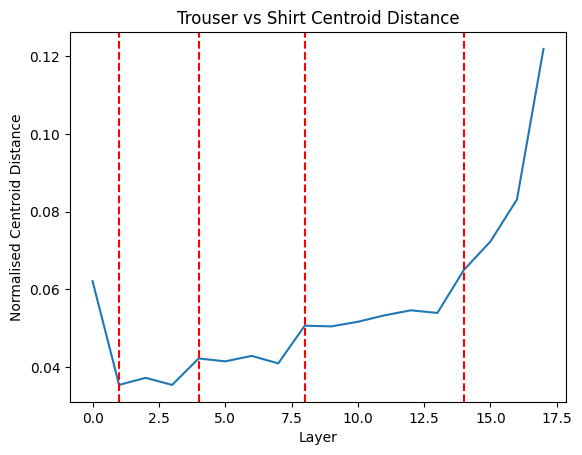

In [8]:
fig, ax = plt.subplots()
activations1 = ResNetActivations2(train_set.class_to_idx["Trouser"], classification_model, test_set, layers, n_points=100)
activations2 = ResNetActivations2(train_set.class_to_idx["Shirt"], classification_model, test_set, layers, n_points=100)
distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    distances.append(distance.to(cpu))
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel('Layer')
ax.set_ylabel('Normalised Centroid Distance')
ax.set_title('Trouser vs Shirt Centroid Distance')
fig.savefig('figures/fashionMNSIT_distance_plot_trouser_shirt.pdf')

In [11]:
distances[-1]

tensor(0.1239)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


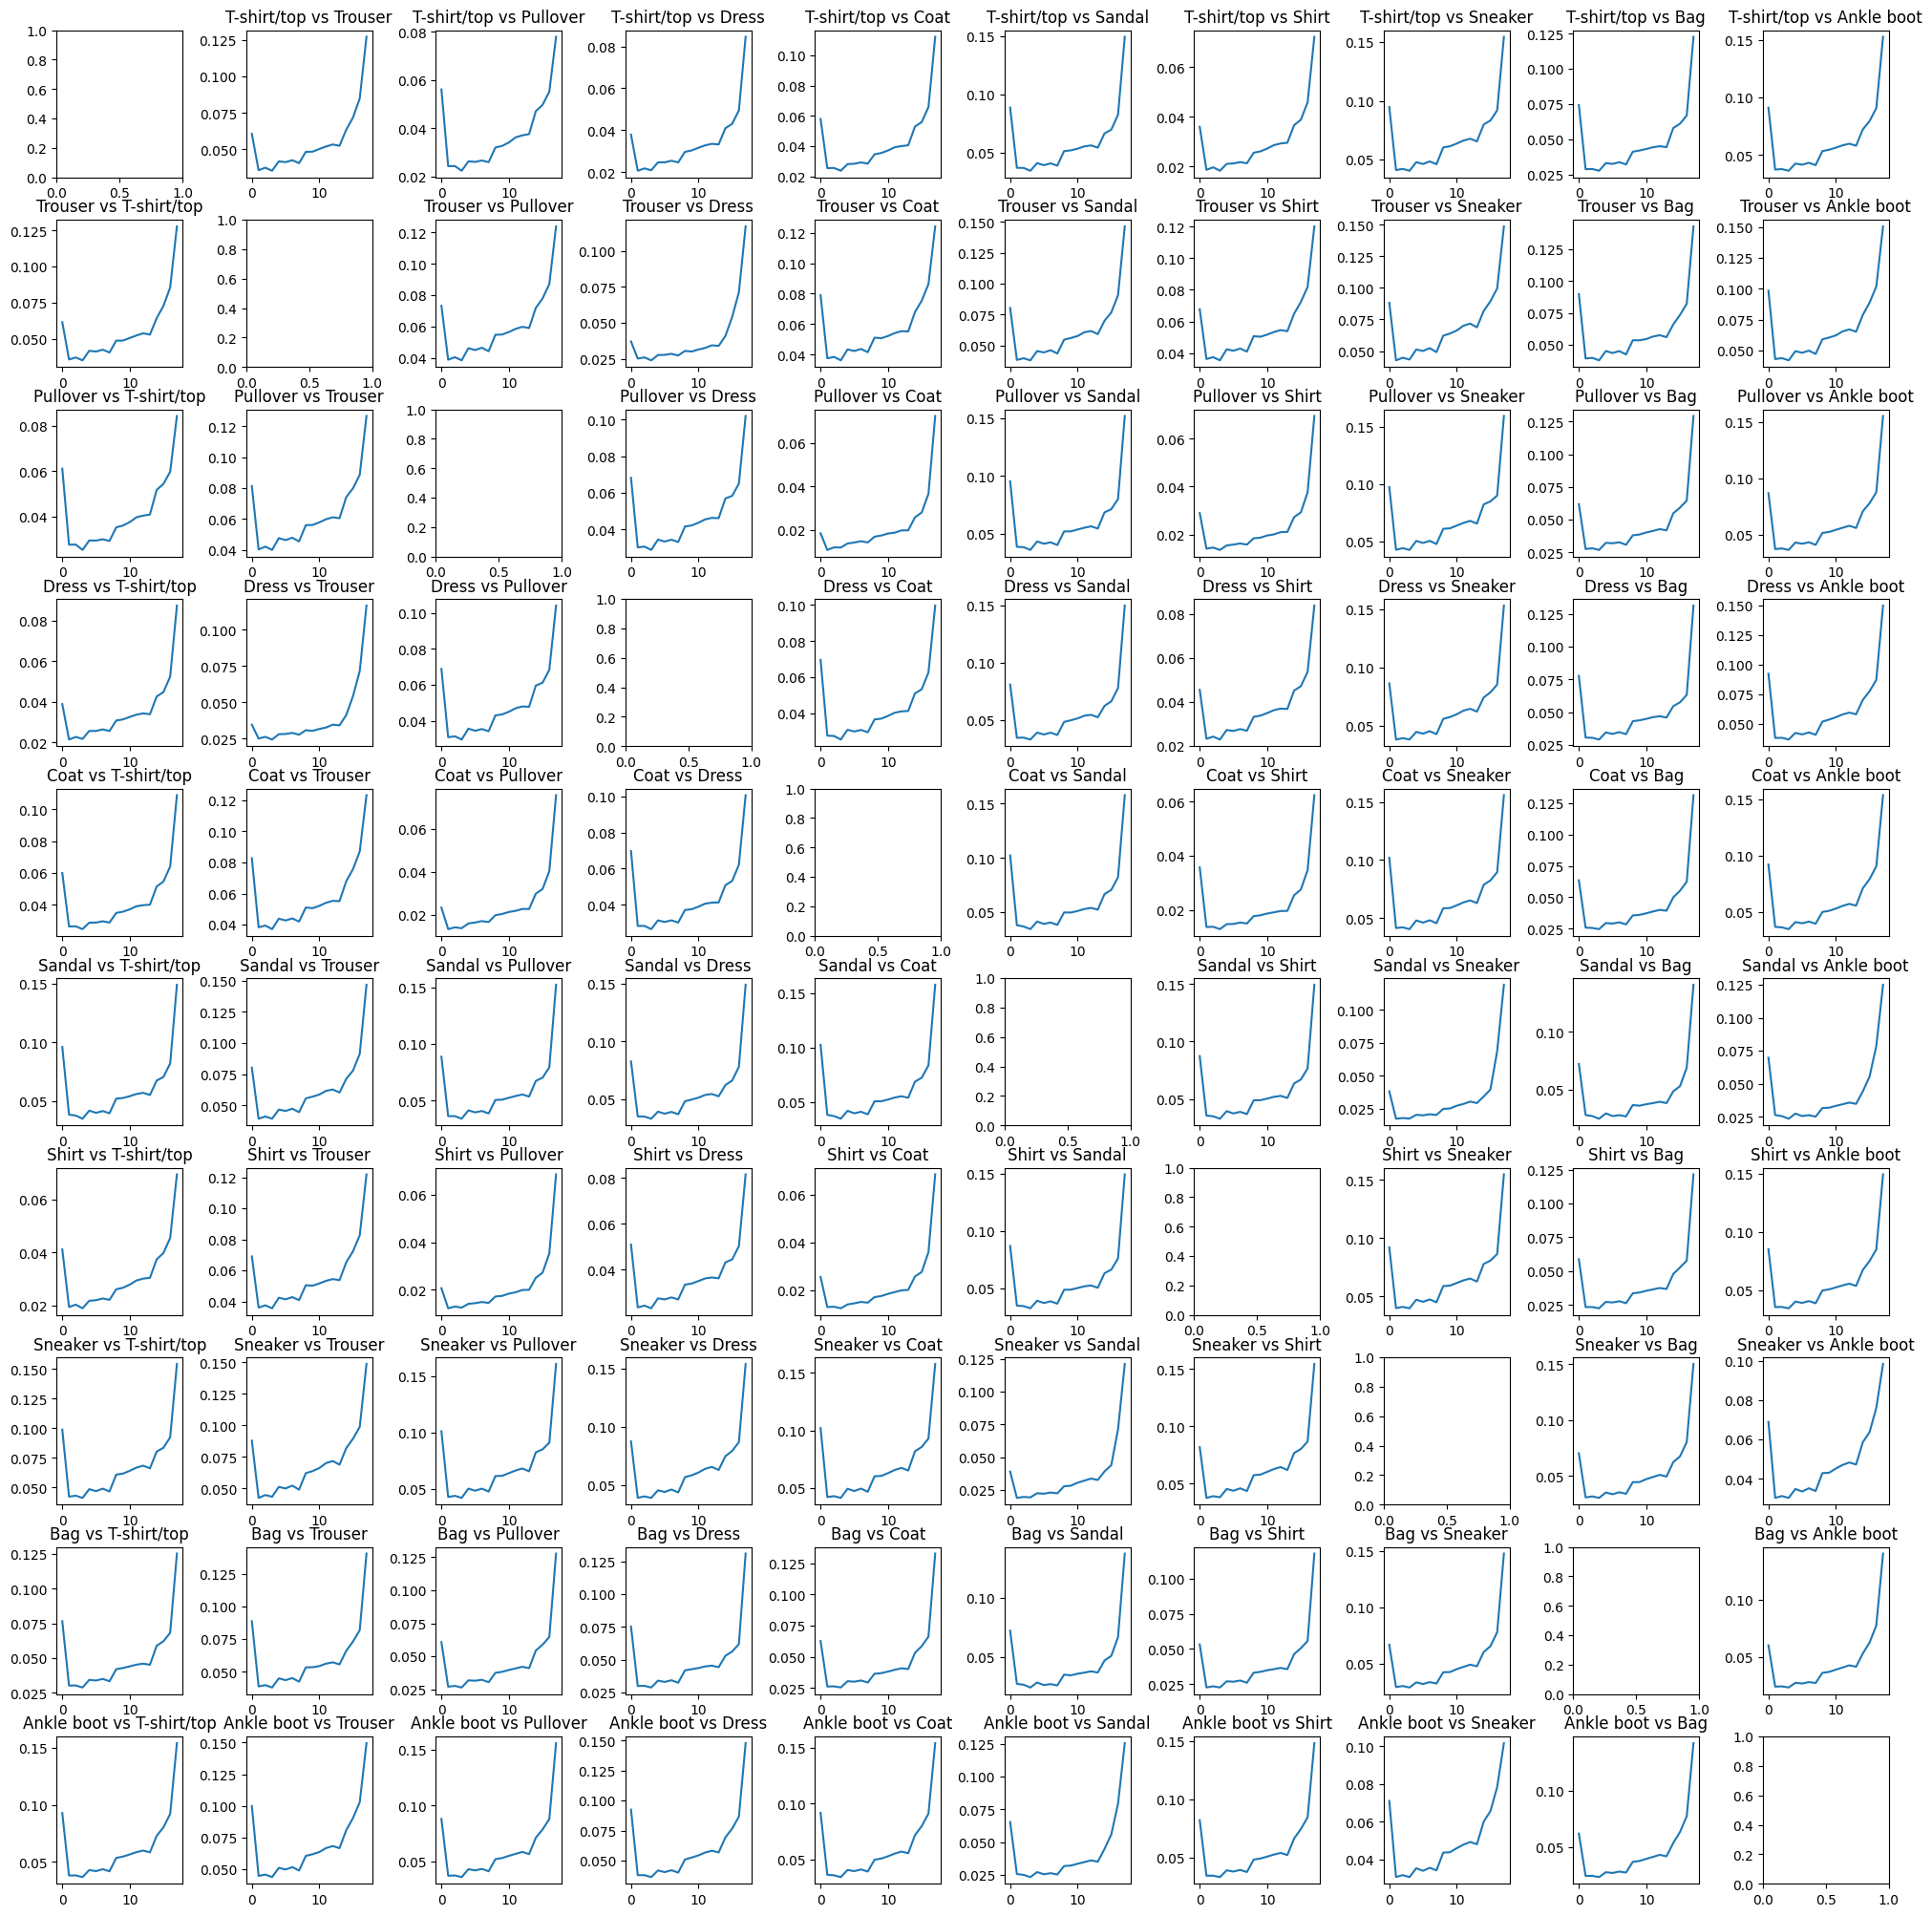

In [8]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for i in range(10):
    activations1 = ResNetActivations2(i, classification_model, test_set, layers, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations2(j, classification_model, test_set, layers, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            centroid1 = act1.mean(dim=0)
            centroid2 = act2.mean(dim=0)
            distance = torch.dist(centroid1, centroid2, p=2)
            distances.append(distance.to(cpu))
            del act1, act2, centroid1, centroid2, distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/distances_fashionMNIST.pdf")

In [7]:
def ResNetActivations3(target_class, model, data, layers, n_points=100):
    """
    Returns the activations of the target class for the given layers.

    Args:
        target_class: The target
        class to get activations for.
        model: The model to get activations from.
        data: The data to get activations from.
        layers: The layers to get activations from.
        n_points: The number of points to get activations for.

    Returns:
        Generator of activations for each layer.
    """
    # Define callback function for layer hooks
    class_indices = [i for i, (_, label) in enumerate(data) if label == target_class]
    selected_indices = np.random.choice(class_indices, n_points, replace=False)
    selected_data = torch.utils.data.Subset(data, selected_indices)
    loader = torch.utils.data.DataLoader(selected_data, batch_size=n_points)
    activations = []
    def get_activation(name):
        def hook(model, input, output):
            # normalize output
            output1 = output
            activations.append(output1.detach())
        return hook
    
    for layer in layers:
        handle = layer.register_forward_hook(get_activation(layer))
        with torch.no_grad():
            for batch, _ in loader:
                model(batch.to(device))
        handle.remove()
        yield activations[0]
        del activations
        activations = []

In [13]:
activations1 = ResNetActivations3(train_set.class_to_idx["Trouser"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["Shirt"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    print(f"Mean normalised cosine distances for layer {i+1}: {1 - distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised cosine distances for layer 1: 0.5738542079925537
Mean normalised cosine distances for layer 2: 0.2754979729652405
Mean normalised cosine distances for layer 3: 0.3812146782875061
Mean normalised cosine distances for layer 4: 0.5205371379852295
Mean normalised cosine distances for layer 5: 0.8829711079597473


In [14]:
activations1 = ResNetActivations3(train_set.class_to_idx["Trouser"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["Shirt"], classification_model, test_set, [classification_model.conv1, classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
    print(f"Cosine Distance between centroids for layer {i+1}: {cos_distance.item()}")
    del act1, act2, centroid1, centroid2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Cosine Distance between centroids for layer 1: 0.2192476987838745
Cosine Distance between centroids for layer 2: 0.06985217332839966
Cosine Distance between centroids for layer 3: 0.10368287563323975
Cosine Distance between centroids for layer 4: 0.1949472427368164
Cosine Distance between centroids for layer 5: 0.6979497671127319


c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


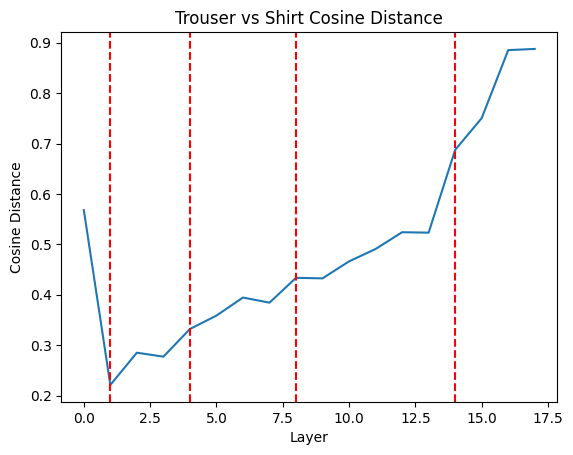

In [8]:
fig, ax = plt.subplots()
activations1 = ResNetActivations3(train_set.class_to_idx["Trouser"], classification_model, test_set, layers, n_points=100)
activations2 = ResNetActivations3(train_set.class_to_idx["Shirt"], classification_model, test_set, layers, n_points=100)
distances_arr = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distance = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    cos_distance = 1 - distance.mean()
    distances_arr.append(cos_distance.to(cpu))
    del act1, act2
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers)), distances_arr)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel('Layer')
ax.set_ylabel('Cosine Distance')
ax.set_title('Trouser vs Shirt Cosine Distance')
fig.savefig('figures/fashionMNIST_cosine_distance_plot_trouser_shirt.pdf')

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


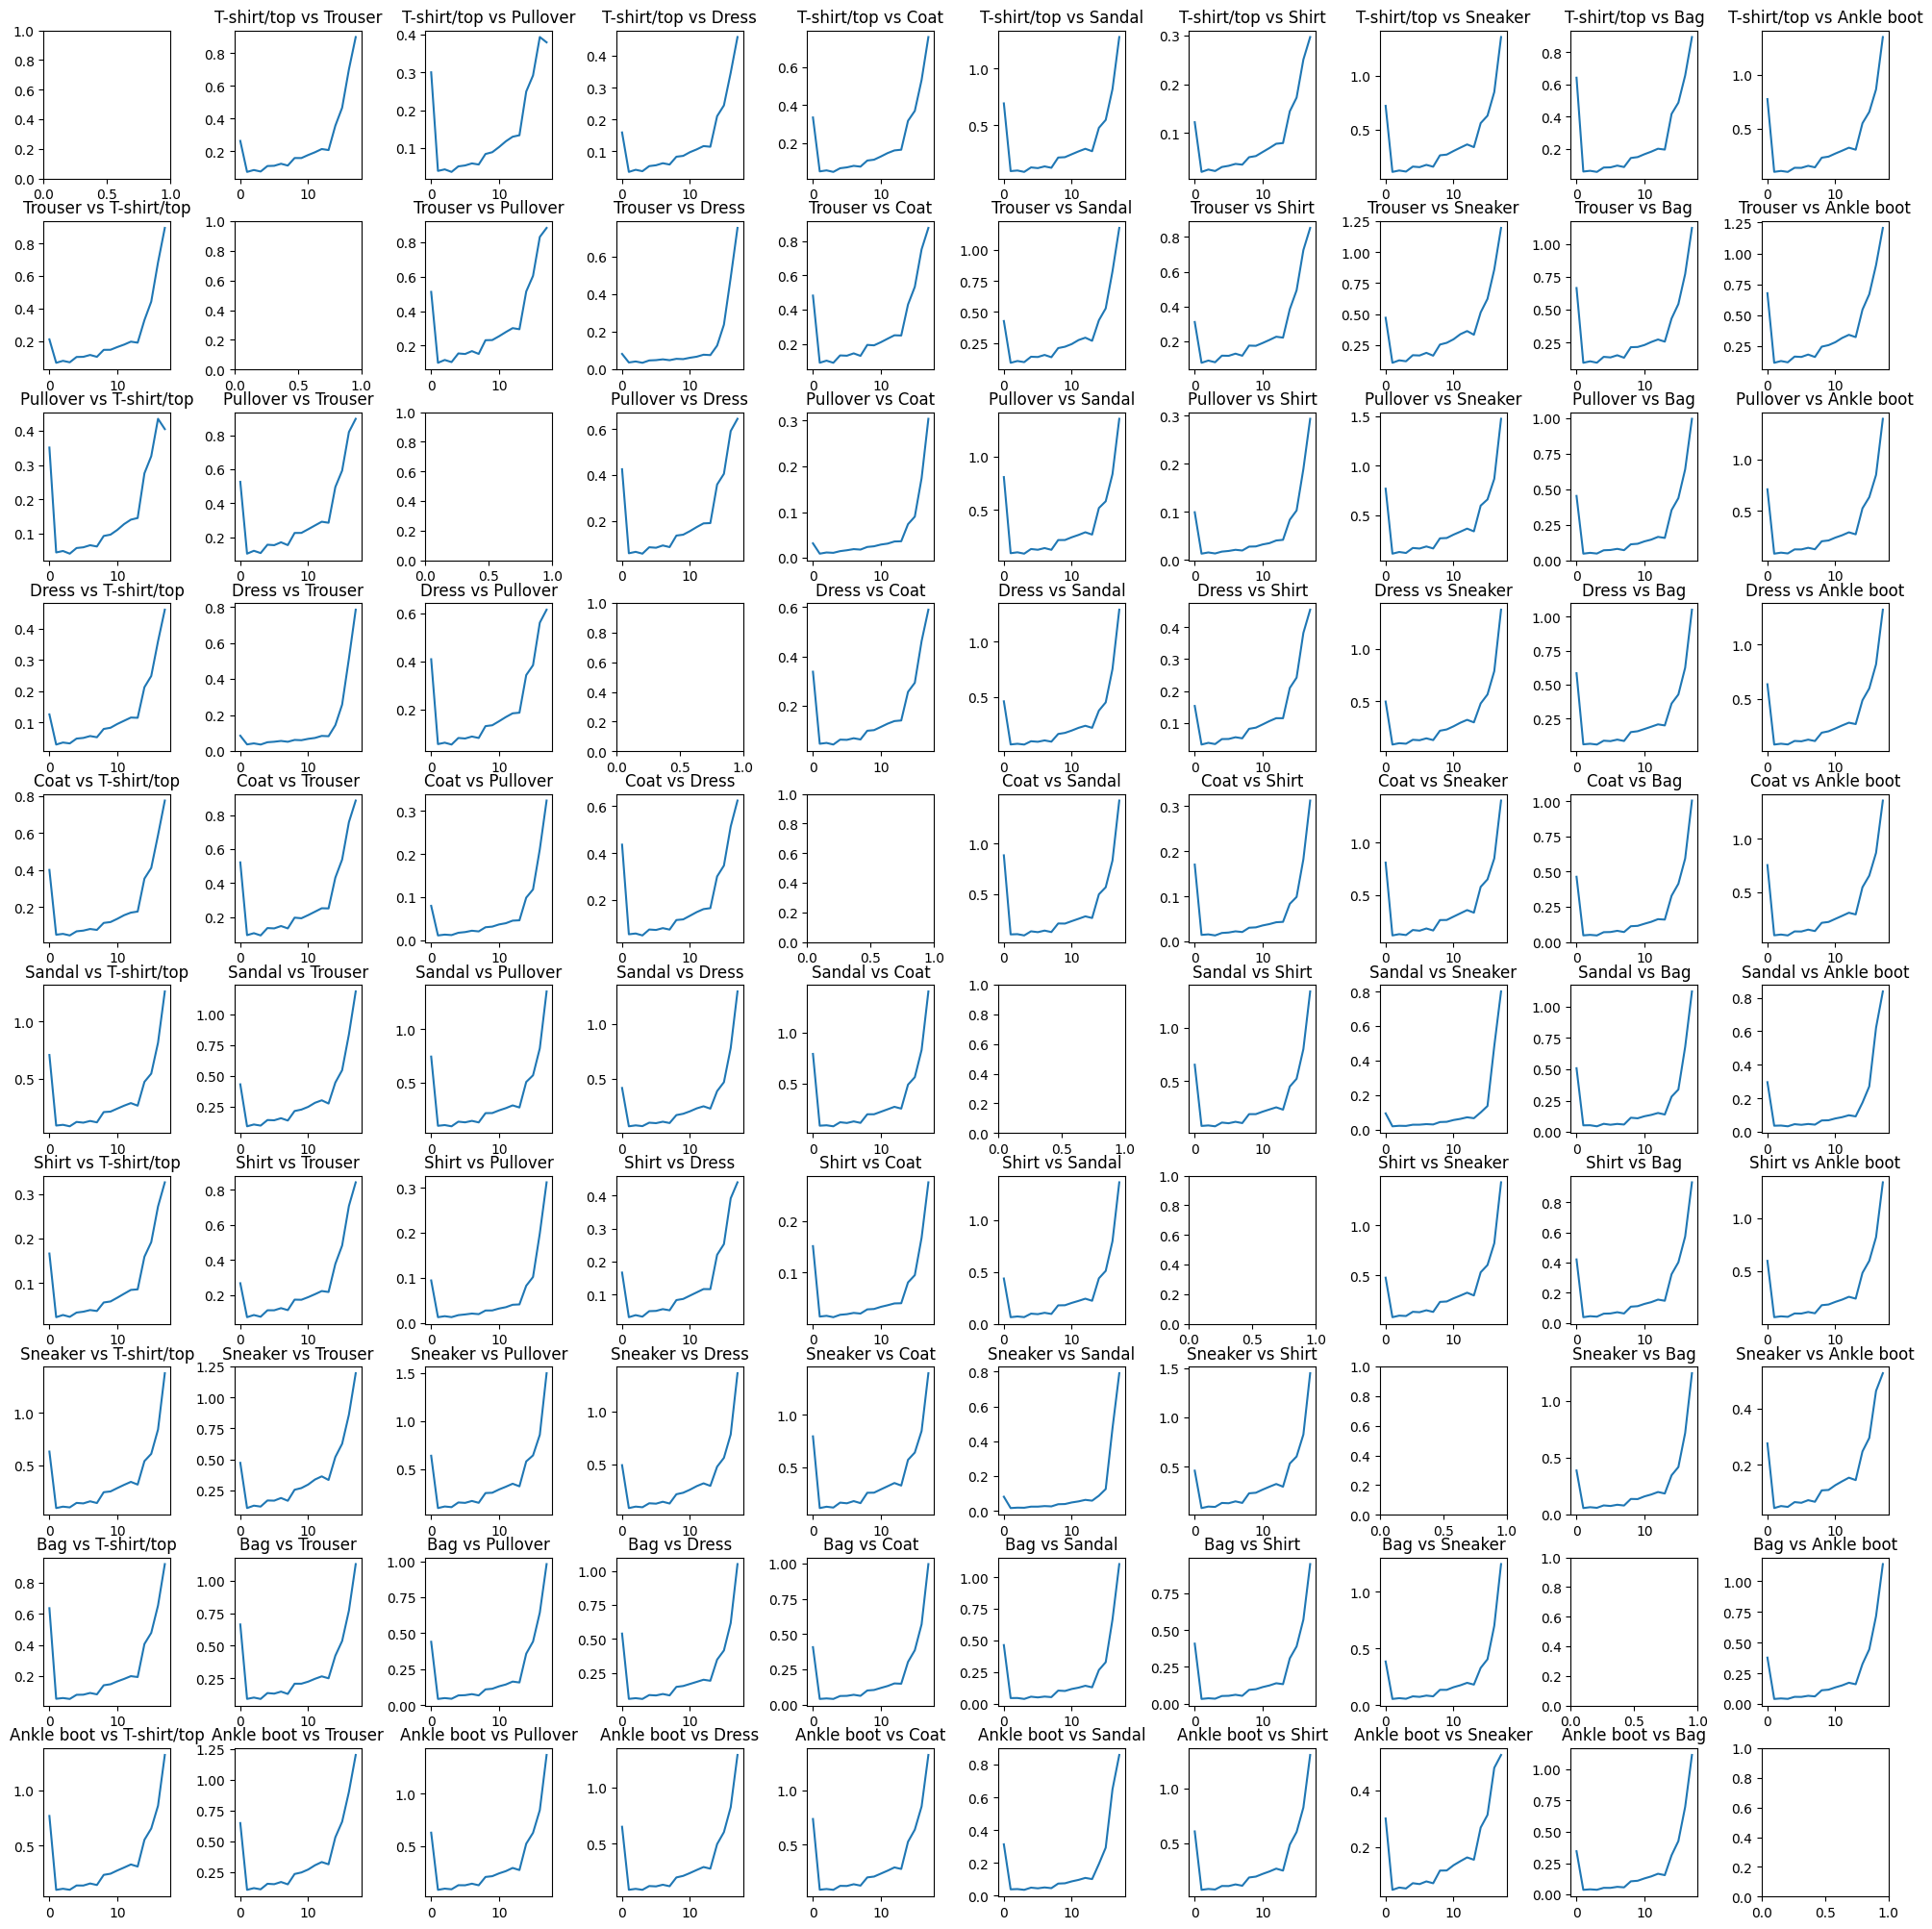

In [9]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for i in range(10):
    activations1 = ResNetActivations3(i, classification_model, test_set, layers, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations3(j, classification_model, test_set, layers, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            centroid1 = act1.mean(dim=0)
            centroid2 = act2.mean(dim=0)
            cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
            distances.append(cos_distance.item())
            del act1, act2, centroid1, centroid2, cos_distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()

In [10]:
fig.savefig("figures/cosine_distances_fashionMNIST.pdf")

In [6]:
classification_model2 = torch.load('resnet50_fashion_mnist_1_epoch.pth').to(device)

In [17]:
activations1 = ResNetActivations2(train_set.class_to_idx["Trouser"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["Shirt"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.cdist(act1.view(100, -1), act2.view(100, -1))
    print(f"Mean normalised distances for layer {i+1}: {distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised distances for layer 1: 0.10652947425842285
Mean normalised distances for layer 2: 0.07584251463413239
Mean normalised distances for layer 3: 0.0895121842622757
Mean normalised distances for layer 4: 0.10626088827848434
Mean normalised distances for layer 5: 0.13524602353572845


In [18]:
activations1 = ResNetActivations2(train_set.class_to_idx["Trouser"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations2(train_set.class_to_idx["Shirt"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    print(f"Distance between centroids for layer {i+1}: {distance}")
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Distance between centroids for layer 1: 0.06292247027158737
Distance between centroids for layer 2: 0.03557422757148743
Distance between centroids for layer 3: 0.0397634394466877
Distance between centroids for layer 4: 0.0460335947573185
Distance between centroids for layer 5: 0.04496057704091072


In [11]:
layers2 = [  
            classification_model2.conv1, 
            classification_model2.layer1[0],
            classification_model2.layer1[1],
            classification_model2.layer1[2],
            classification_model2.layer2[0],
            classification_model2.layer2[1],
            classification_model2.layer2[2],
            classification_model2.layer2[3],
            classification_model2.layer3[0],
            classification_model2.layer3[1],
            classification_model2.layer3[2],
            classification_model2.layer3[3],
            classification_model2.layer3[4],
            classification_model2.layer3[5],
            classification_model2.layer4[0],
            classification_model2.layer4[1],
            classification_model2.layer4[2],
            classification_model2.fc
]

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


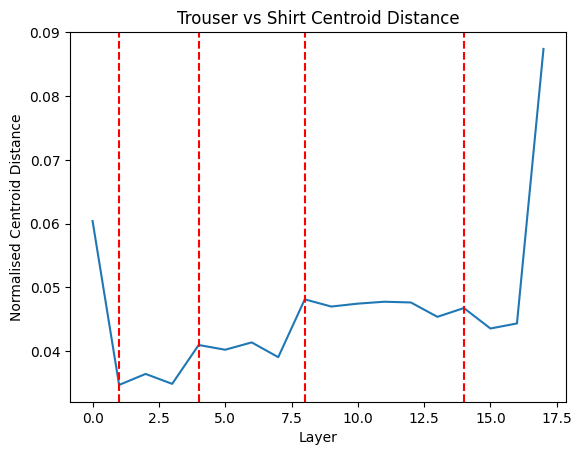

In [8]:
fig, ax = plt.subplots()
activations1 = ResNetActivations2(train_set.class_to_idx["Trouser"], classification_model2, test_set, layers2, n_points=100)
activations2 = ResNetActivations2(train_set.class_to_idx["Shirt"], classification_model2, test_set, layers2, n_points=100)
distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    distance = torch.dist(centroid1, centroid2, p=2)
    distances.append(distance.to(cpu))
    del act1, act2, centroid1, centroid2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
ax.plot(range(len(layers2)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel('Layer')
ax.set_ylabel('Normalised Centroid Distance')
ax.set_title('Trouser vs Shirt Centroid Distance')
fig.savefig('figures/fashionMNIST_distance_plot_trouser_shirt_1_epoch.pdf')

In [21]:
distances[-1]

tensor(0.0880)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


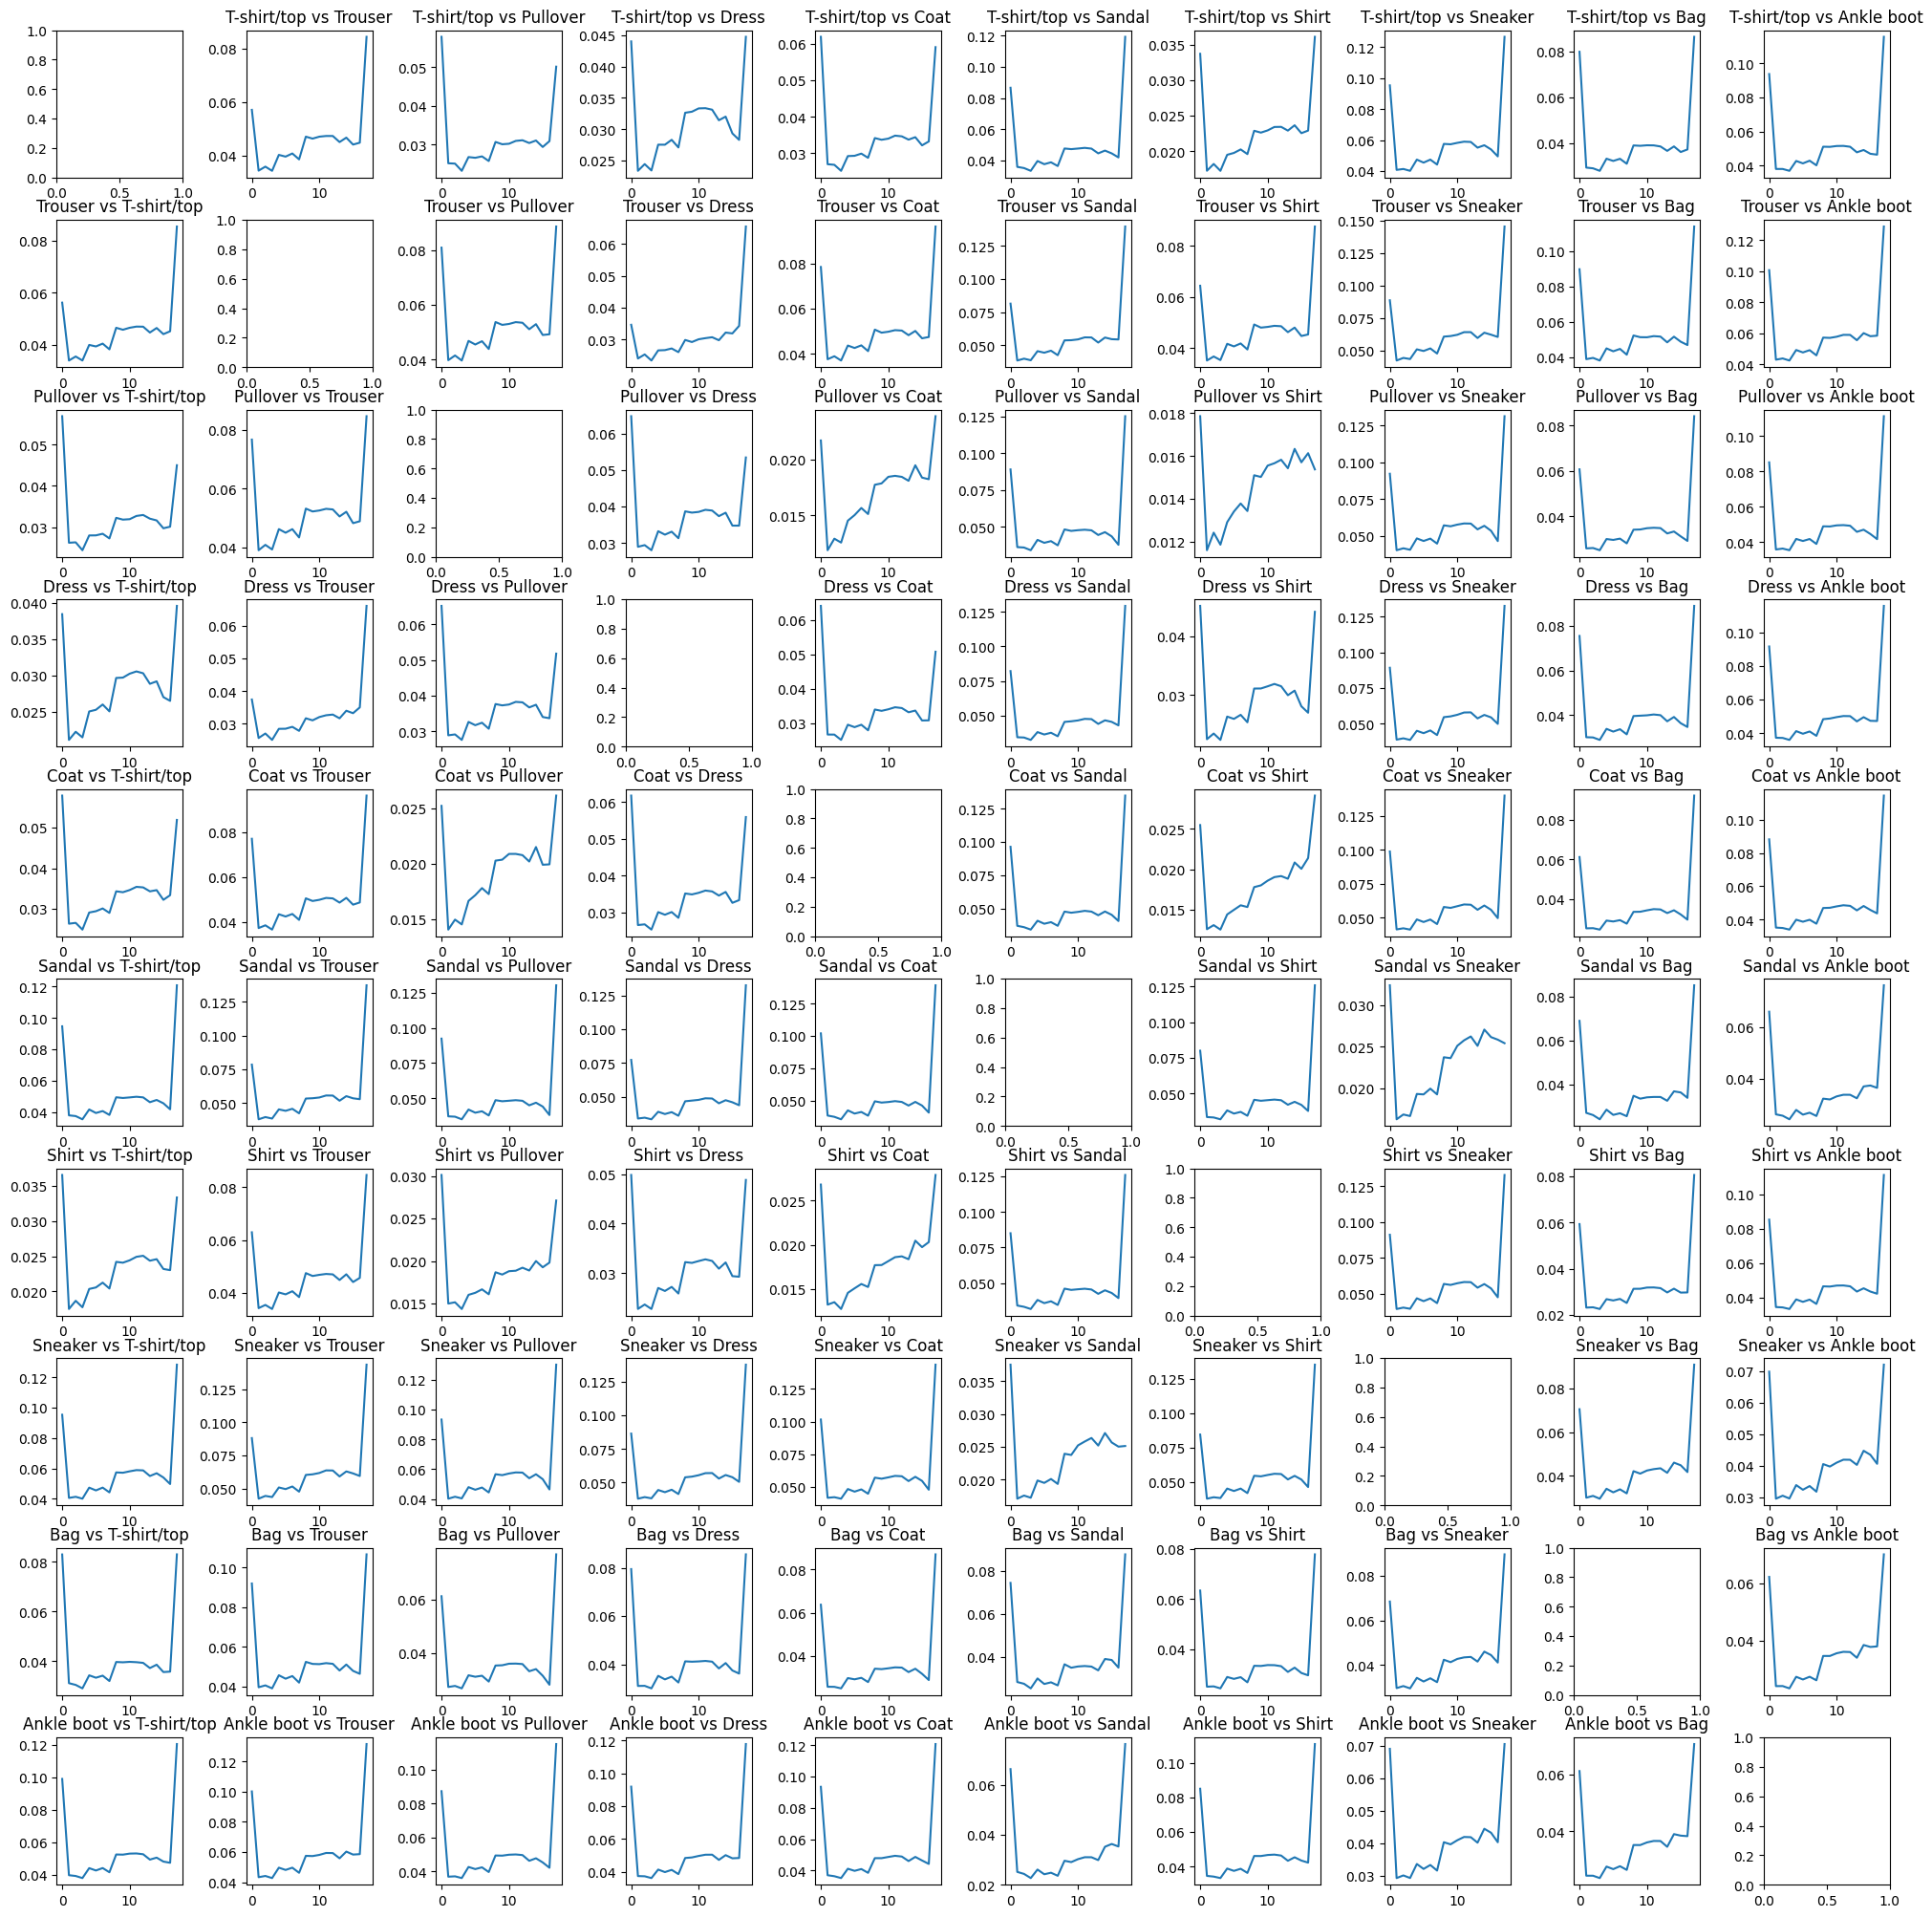

In [11]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()
for i in range(10):
    activations1 = ResNetActivations2(i, classification_model2, test_set, layers2, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations2(j, classification_model2, test_set, layers2, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            centroid1 = act1.mean(dim=0)
            centroid2 = act2.mean(dim=0)
            distance = torch.dist(centroid1, centroid2, p=2)
            distances.append(distance.to(cpu))
            del act1, act2, centroid1, centroid2, distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
fig.savefig("figures/distances_fashionMNIST_1_epoch.pdf")

In [22]:
activations1 = ResNetActivations3(train_set.class_to_idx["Trouser"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["Shirt"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distances = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    print(f"Mean normalised cosine distances for layer {i+1}: {1 - distances.mean()}")
    del act1, act2, distances
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Mean normalised cosine distances for layer 1: 0.5467438697814941
Mean normalised cosine distances for layer 2: 0.2817234992980957
Mean normalised cosine distances for layer 3: 0.39581066370010376
Mean normalised cosine distances for layer 4: 0.5600149631500244
Mean normalised cosine distances for layer 5: 0.9254747033119202


In [23]:
activations1 = ResNetActivations3(train_set.class_to_idx["Trouser"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])
activations2 = ResNetActivations3(train_set.class_to_idx["Shirt"], classification_model2, test_set, [classification_model2.conv1, classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4])

for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    centroid1 = act1.mean(dim=0)
    centroid2 = act2.mean(dim=0)
    cos_distance = 1 - torch.mm(F.normalize(centroid1.view(1, -1), p=2, dim=1), F.normalize(centroid2.view(1, -1), p=2, dim=1).T)
    print(f"Cosine Distance between centroids for layer {i+1}: {cos_distance.item()}")
    del act1, act2, centroid1, centroid2, cos_distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()

Cosine Distance between centroids for layer 1: 0.31008756160736084
Cosine Distance between centroids for layer 2: 0.07990050315856934
Cosine Distance between centroids for layer 3: 0.11314207315444946
Cosine Distance between centroids for layer 4: 0.1879521608352661
Cosine Distance between centroids for layer 5: 0.5117093324661255


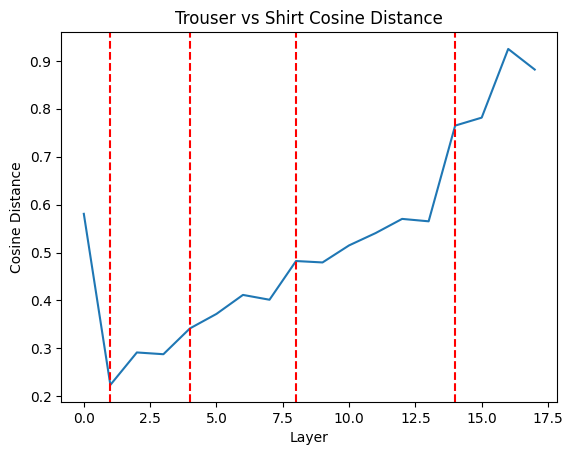

In [13]:
fig, ax = plt.subplots()
activations1 = ResNetActivations3(train_set.class_to_idx["Trouser"], classification_model2, test_set, layers2, n_points=100)
activations2 = ResNetActivations3(train_set.class_to_idx["Shirt"], classification_model2, test_set, layers2, n_points=100)

distances = []
for i, (act1, act2) in enumerate(zip(activations1, activations2)):
    distance = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
    distances.append(1 - distance.mean().to(cpu))
    del act1, act2, distance
    torch.cuda.empty_cache()
torch.cuda.empty_cache()
del activations1, activations2
torch.cuda.empty_cache()
#print(distances)
ax.plot(range(len(layers2)), distances)
ax.axvline(1, color='red', linestyle='--')
ax.axvline(4, color='red', linestyle='--')
ax.axvline(8, color='red', linestyle='--')
ax.axvline(14, color='red', linestyle='--')
ax.set_xlabel('Layer')
ax.set_ylabel('Cosine Distance')
ax.set_title('Trouser vs Shirt Cosine Distance')
fig.savefig('figures/fashionMNIST_cosine_distance_plot_trouser_shirt_1_epoch.pdf')

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


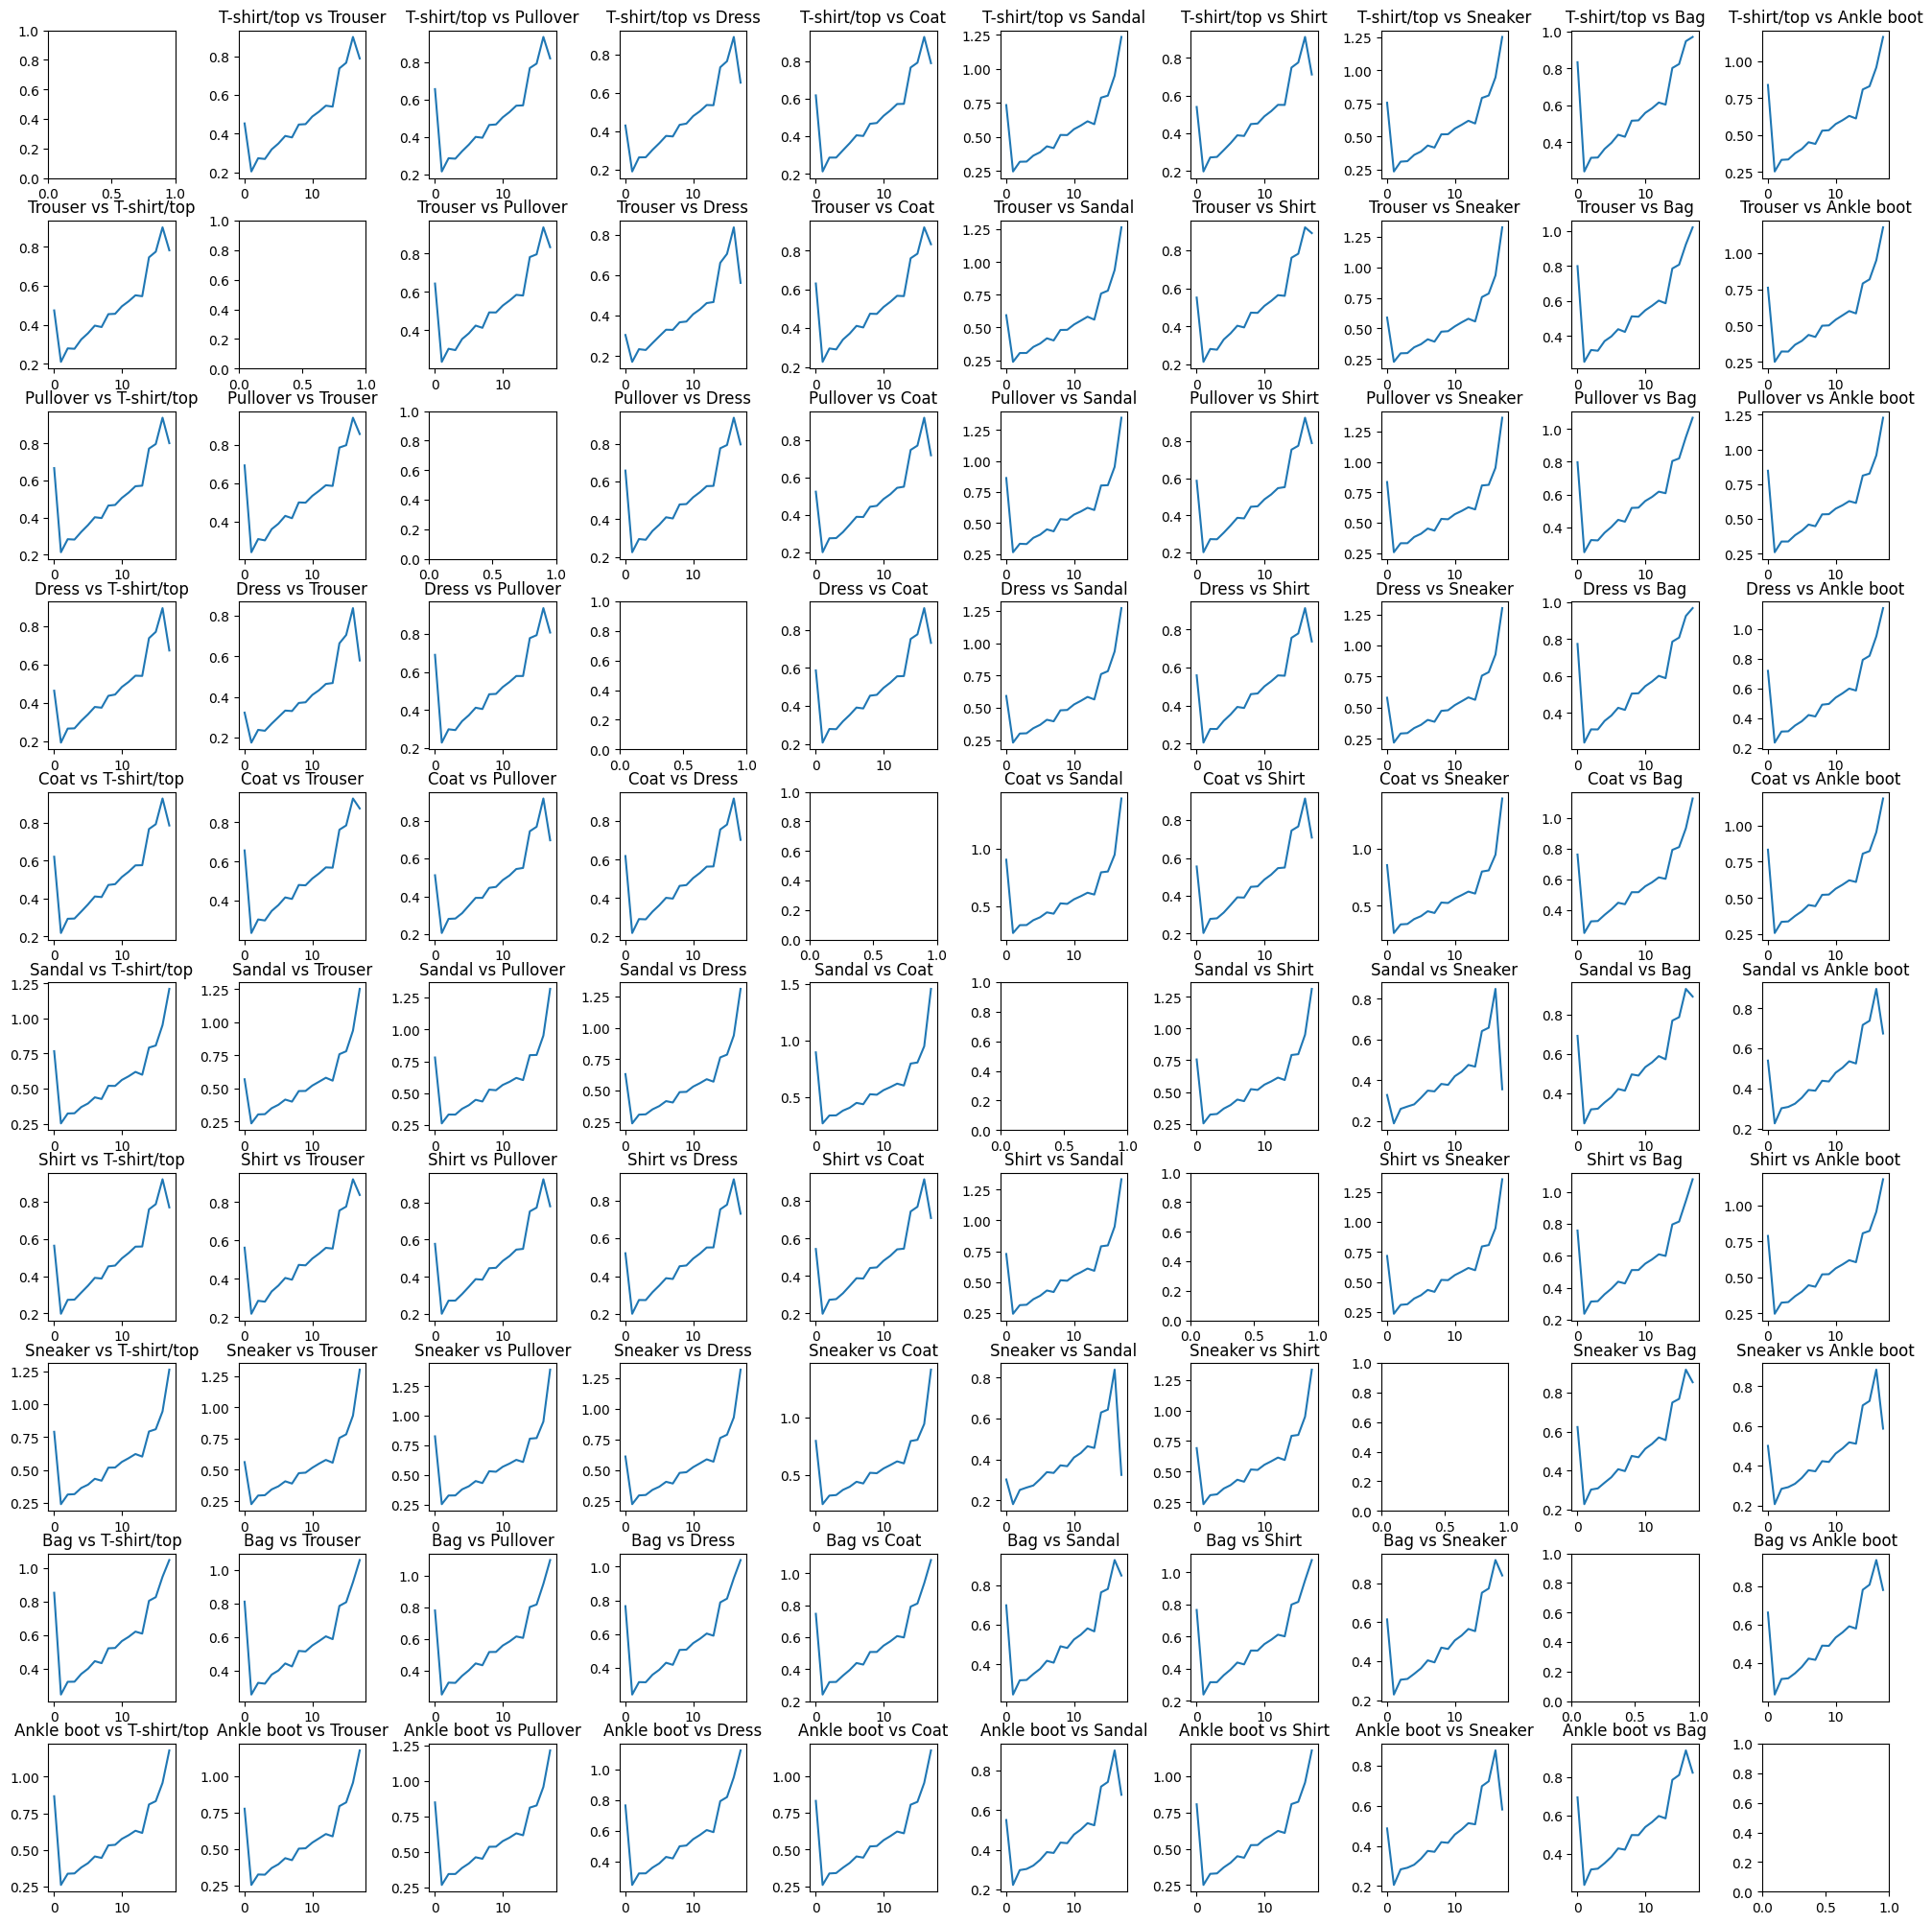

In [14]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout()

for i in range(10):
    activations1 = ResNetActivations3(i, classification_model2, test_set, layers2, n_points=100)
    activations1 = list(activations1)
    class_name_1 = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    for j in range(10):
        if i == j:
            continue
        class_name_2 = [k for k, v in train_set.class_to_idx.items() if v == j][0]
        activations2 = ResNetActivations3(j, classification_model2, test_set, layers2, n_points=100)
        distances = []
        for k, (act1, act2) in enumerate(zip(activations1, activations2)):
            distance = torch.mm(F.normalize(act1.view(100, -1), p=2, dim=1), F.normalize(act2.view(100, -1), p=2, dim=1).T)
            distances.append(1 - distance.mean().to(cpu))
            del act1, act2, distance
            torch.cuda.empty_cache()
        del activations2
        torch.cuda.empty_cache()
        ax[i, j].plot(range(len(layers2)), distances)
        ax[i, j].set_title(f"{class_name_1} vs {class_name_2}")
    del activations1
    torch.cuda.empty_cache()

In [15]:
fig.savefig("figures/cosine_distances_fashionMNIST_1_epoch.pdf")

In [25]:
distances[-1]

0.6559926271438599

In [7]:
class SplitResNet(nn.Module):
    def __init__(self, model, layer_hierarchy):
        super(SplitResNet, self).__init__()
        # self.model = model
        self.part1 = nn.Sequential()
        self.part2 = nn.Sequential()

        for i, (name, module) in enumerate(model.named_children()):
            if i == layer_hierarchy[0]:
                if len(layer_hierarchy) == 1:
                    self.part1.add_module(name, module)
                else:
                    former_module, latter_module = self._add_module(module, layer_hierarchy[1:])
                    self.part1.add_module(name, former_module)
                    self.part2.add_module(name, latter_module)
            elif i < layer_hierarchy[0]:
                self.part1.add_module(name, module)
            else:
                self.part2.add_module(name, module)

    def _add_module(self, module, layer_hierarchy):
        # print(layer_hierarchy, module)
        former_module, latter_module = nn.Sequential(), nn.Sequential()
        for i, (name, layer) in enumerate(module.named_children()):
            # print(name)
            if i == layer_hierarchy[0]:
                if len(layer_hierarchy) == 1:
                    # print('check')
                    former_module.add_module(name, layer)
                else:
                    # print('run')
                    former_layer, latter_layer = self._add_module(layer, layer_hierarchy[1:])
                    former_module.add_module(name, former_layer)
                    latter_module.add_module(name, latter_layer)
            elif i < layer_hierarchy[0]:
                former_module.add_module(name, layer)
            else:
                latter_module.add_module(name, layer)
        return former_module, latter_module

    def forward(self, x, mode='latter'):
        for module in self.part2[:-1]:
            x = module(x)
        x = torch.flatten(x, 1)
        return self.part2[-1](x)
        # if mode == 'latter':
        #     return self.part2(x)
        # if mode == 'former':
        #     return self.part1(x)
        # if mode == 'all_as_one_model':
        #     x = self.part1(x)
        #     x1 = self.part2(x)
        #     return x, x1
        # if mode == 'all_as_two_model':
        #     return self.part1(x), self.part2(x)

In [66]:
# See if for a perturbed intermediate activation for a random image, the output changes

split_model = SplitResNet(classification_model, [4])
activations = []
hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
classification_model(train_set[2000][0].unsqueeze(0).to(device))
hook.remove()
perturbed_activations = activations[0] + torch.randn_like(activations[0])*0.5
print(activations[0].shape)

output1 = split_model(perturbed_activations)
perturbed_label = output1.argmax().item()
output2 = classification_model(train_set[2000][0].unsqueeze(0).to(device))
original_label = output2.argmax().item()
print(f"Original label: {original_label}, Perturbed label: {perturbed_label}")

torch.Size([1, 256, 56, 56])
Original label: 4, Perturbed label: 4


In [11]:
# Check if linear interpolation between two intermediate activations results in the same prediction
split_model = SplitResNet(classification_model, [7])
activations = []
hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
class_indices = [i for i, (_, label) in enumerate(test_set) if label == 6]
selected_index_1 = np.random.choice(class_indices)
class_indices.remove(selected_index_1)
selected_index_2 = np.random.choice(class_indices)
classification_model(test_set[selected_index_1][0].unsqueeze(0).to(device))
classification_model(test_set[selected_index_2][0].unsqueeze(0).to(device))
hook.remove()
activation1 = activations[0]
activation2 = activations[1]
interpolated_activation = activation1 + (activation2 - activation1)*0.5
output1 = split_model(interpolated_activation)
label = output1.argmax().item()
print(f"Interpolated label: {label}")

Interpolated label: 6


In [12]:
split_model = SplitResNet(classification_model, [8])
activations = []
hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
class_indices = [i for i, (_, label) in enumerate(test_set) if label == 2]
selected_index_1 = np.random.choice(class_indices)
class_indices.remove(selected_index_1)
selected_index_2 = np.random.choice(class_indices)
classification_model(test_set[selected_index_1][0].unsqueeze(0).to(device))
classification_model(test_set[selected_index_2][0].unsqueeze(0).to(device))
hook.remove()
activation1 = activations[0]
activation2 = activations[1]
interpolation_weights = torch.linspace(0, 1, 10).to(device)
for weight in interpolation_weights:
    interpolated_activation = torch.lerp(activation1, activation2, weight)
    output1 = split_model(interpolated_activation)
    label = output1.argmax().item()
    print(f"Interpolated label: {label}")

Interpolated label: 2
Interpolated label: 2
Interpolated label: 2
Interpolated label: 2
Interpolated label: 2
Interpolated label: 2
Interpolated label: 2
Interpolated label: 2
Interpolated label: 2
Interpolated label: 2


In [8]:
def class_convexity(target_class, layer, n_pairs=25):
    split_model = SplitResNet(classification_model, [layer])
    activations = []
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == target_class]
    hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
    num_success = 0
    for _ in range(n_pairs):
        selected_index_1 = np.random.choice(class_indices)
        class_indices.remove(selected_index_1)
        selected_index_2 = np.random.choice(class_indices)
        class_indices.remove(selected_index_2)
        classification_model(train_set[selected_index_1][0].unsqueeze(0).to(device))
        classification_model(train_set[selected_index_2][0].unsqueeze(0).to(device))
        activation1 = activations[0]
        activation2 = activations[1]
        interpolation_weights = torch.linspace(0, 1, 10).to(device)
        interpolated_labels = []
        for weight in interpolation_weights:
            interpolated_activation = torch.lerp(activation1, activation2, weight)
            output1 = split_model(interpolated_activation)
            label = output1.argmax().item()
            interpolated_labels.append(label)
        if all([label == interpolated_labels[0] for label in interpolated_labels]):
            num_success += 1
        activations = []
    hook.remove()
    del split_model, activations, interpolated_activation, interpolated_labels, interpolation_weights, activation1, activation2
    torch.cuda.empty_cache()
    return num_success / n_pairs

In [8]:
def class_convexity2(target_class, layer, n_pairs=25):
    split_model = SplitResNet(classification_model2, [layer])
    activations = []
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == target_class]
    hook = split_model.part1[-1].register_forward_hook(lambda self, input, output: activations.append(output))
    num_success = 0
    for _ in range(n_pairs):
        selected_index_1 = np.random.choice(class_indices)
        class_indices.remove(selected_index_1)
        selected_index_2 = np.random.choice(class_indices)
        class_indices.remove(selected_index_2)
        classification_model2(train_set[selected_index_1][0].unsqueeze(0).to(device))
        classification_model2(train_set[selected_index_2][0].unsqueeze(0).to(device))
        activation1 = activations[0]
        activation2 = activations[1]
        interpolation_weights = torch.linspace(0, 1, 10).to(device)
        interpolated_labels = []
        for weight in interpolation_weights:
            interpolated_activation = torch.lerp(activation1, activation2, weight)
            output1 = split_model(interpolated_activation)
            label = output1.argmax().item()
            interpolated_labels.append(label)
        if all([label == interpolated_labels[0] for label in interpolated_labels]):
            num_success += 1
        activations = []
    hook.remove()
    del split_model, activations, interpolated_activation, interpolated_labels, interpolation_weights, activation1, activation2
    torch.cuda.empty_cache()
    return num_success / n_pairs

In [16]:
print(class_convexity(5, 7))
torch.cuda.empty_cache()

1.0


c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


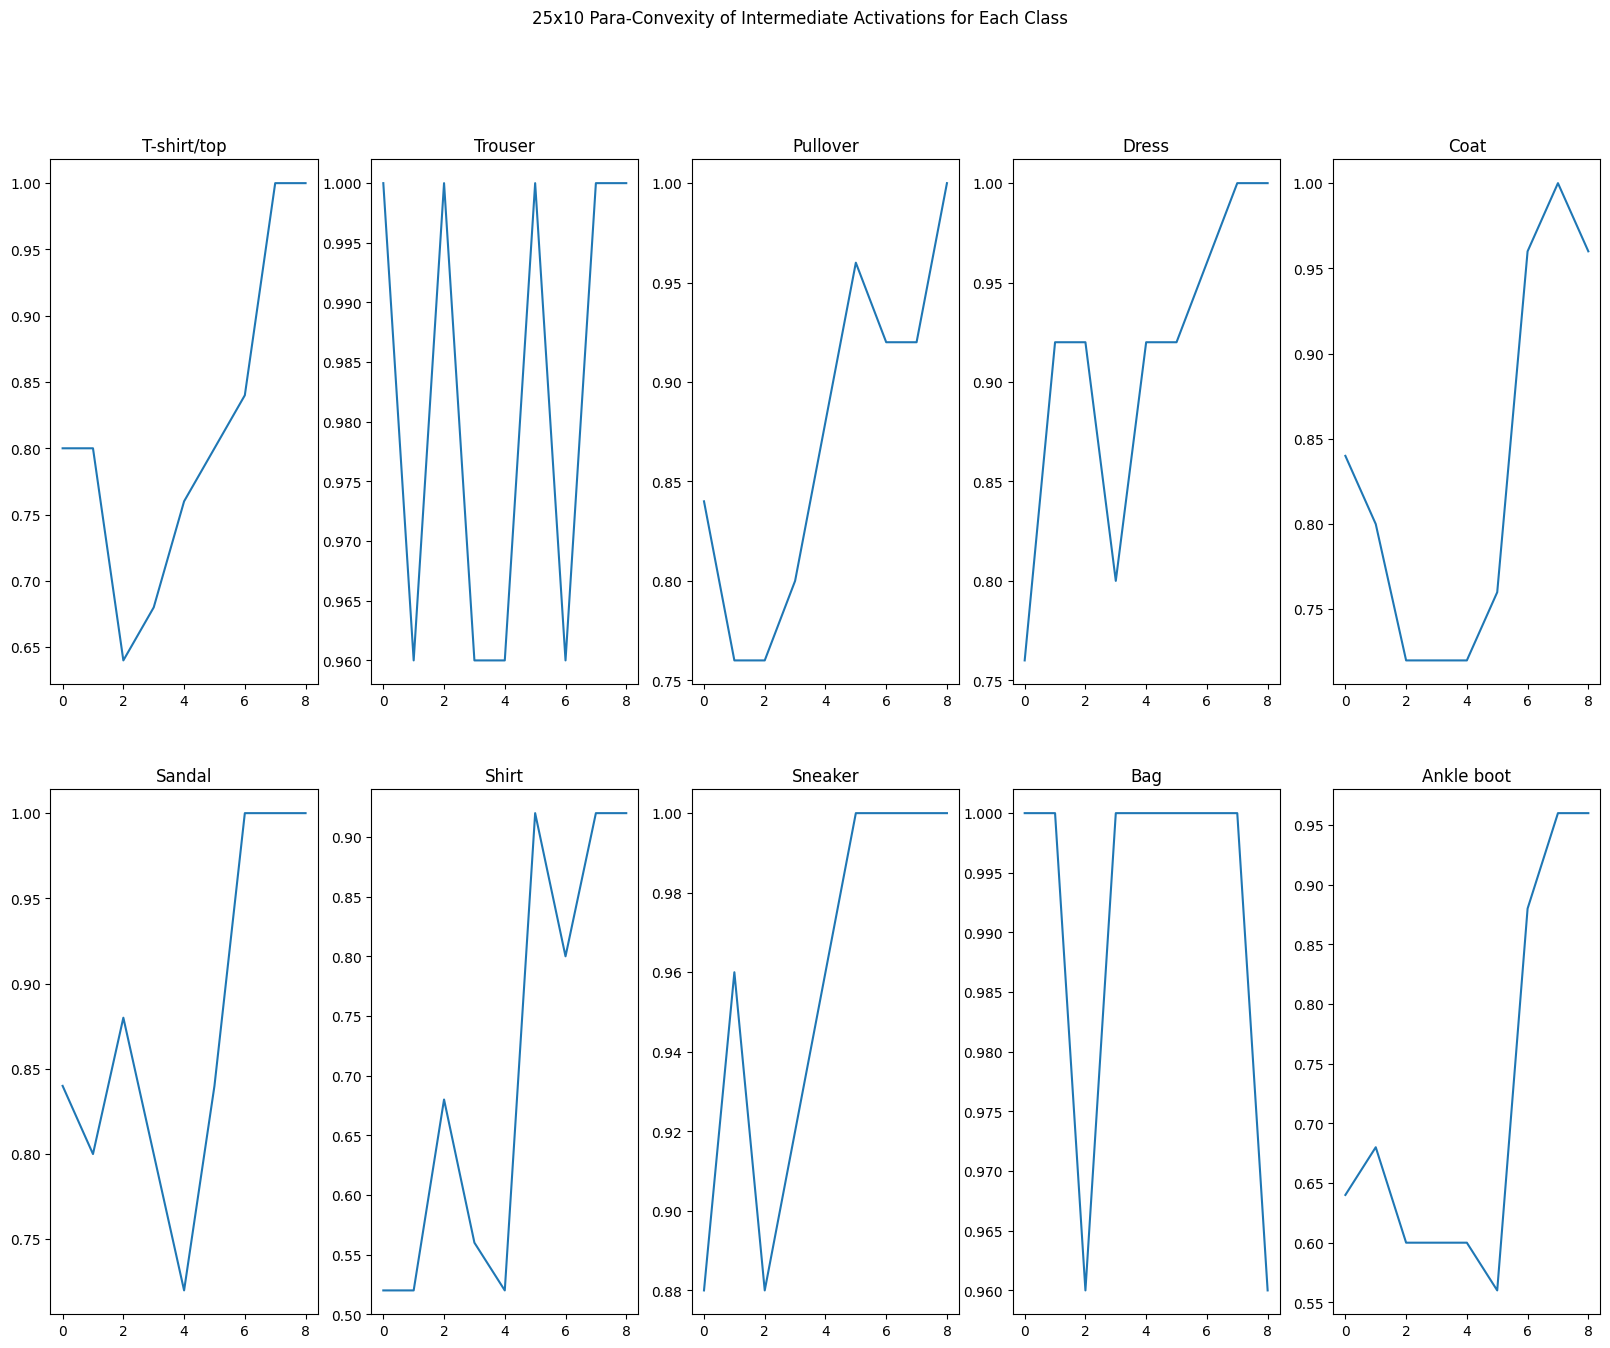

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
#fig.tight_layout()
fig.suptitle("25x10 Para-Convexity of Intermediate Activations for Each Class")
for i in range(10):
    row = i // 5
    col = i % 5
    class_name = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    ax[row, col].plot(range(9), [class_convexity(i, j) for j in range(9)])
    ax[row, col].set_title(class_name)

In [10]:
fig.savefig('figures/pseudo_convexity_fashionMNIST.pdf')

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


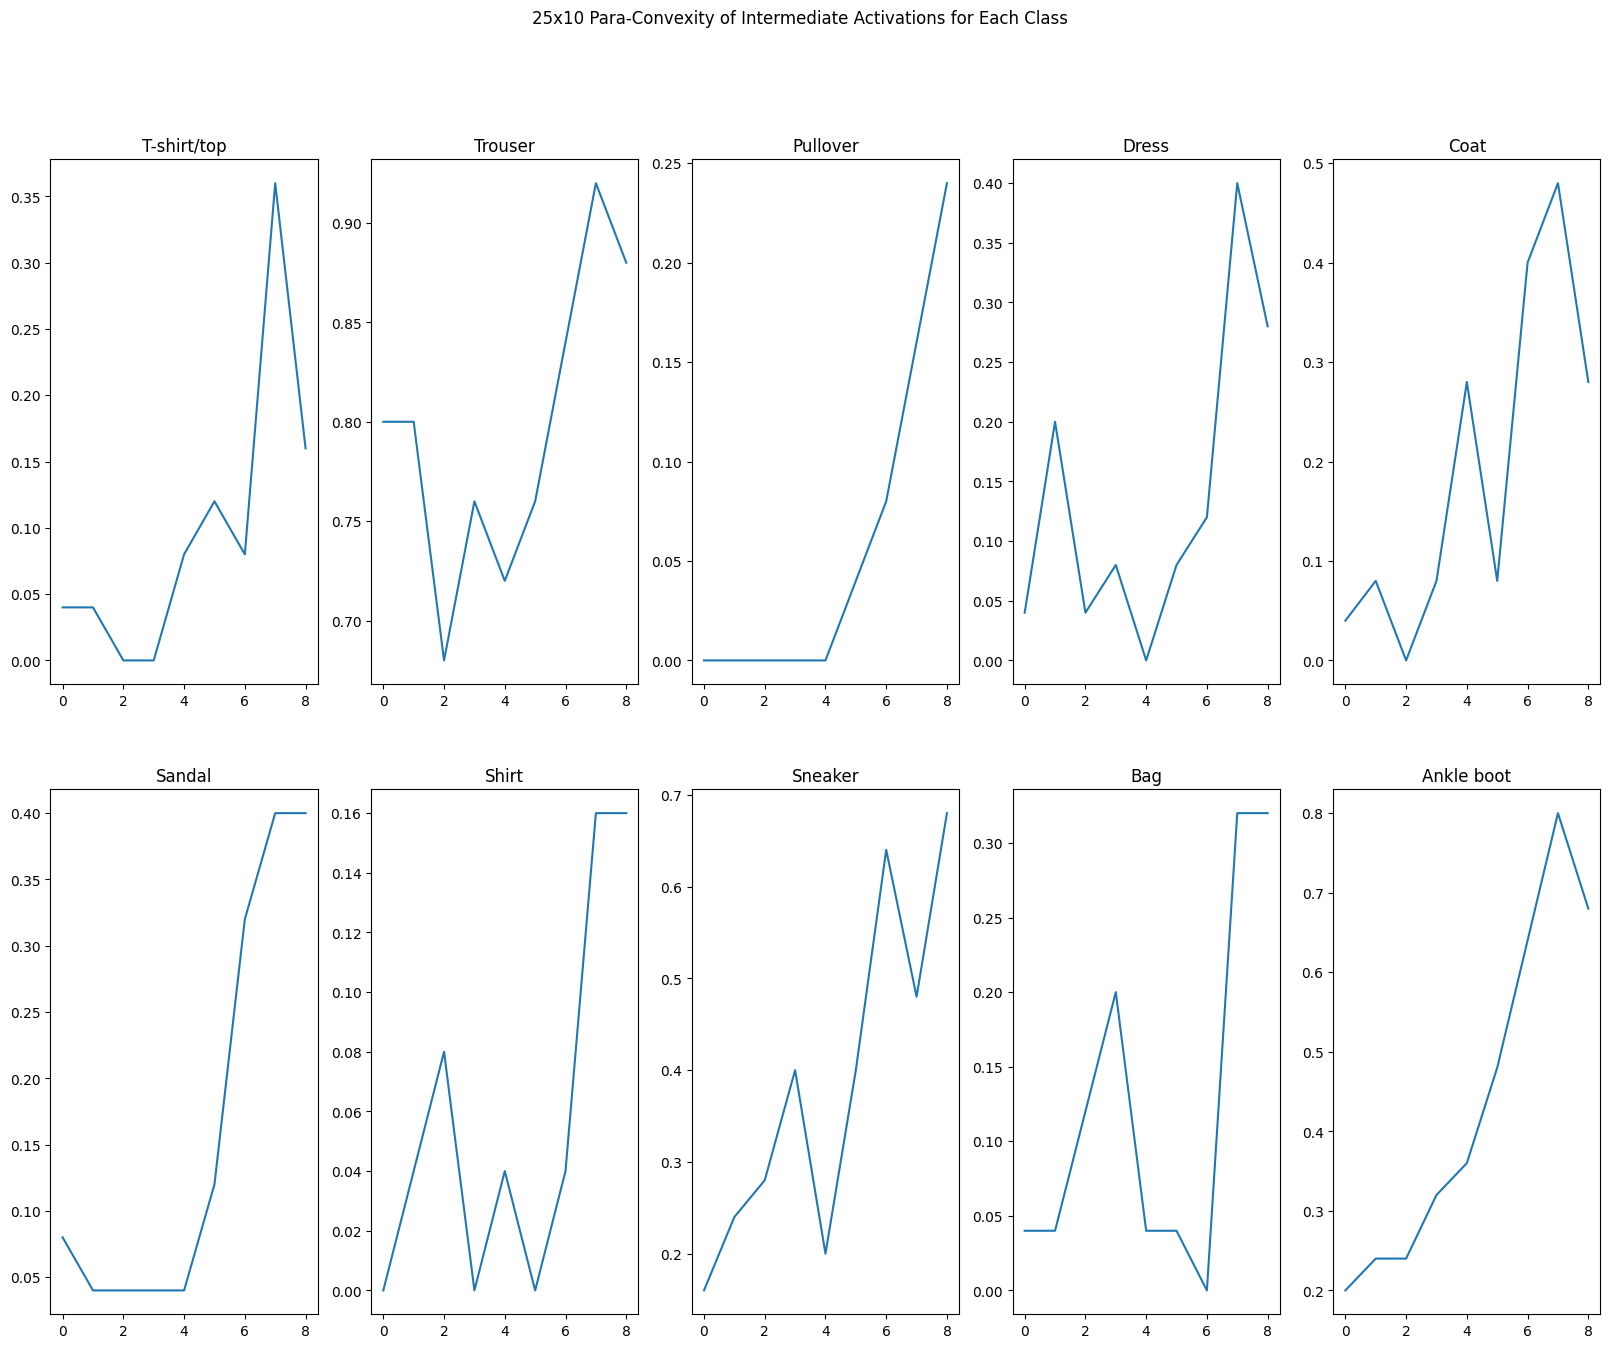

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(20, 15))
#fig.tight_layout()

fig.suptitle("25x10 Para-Convexity of Intermediate Activations for Each Class")
for i in range(10):
    row = i // 5
    col = i % 5
    class_name = [k for k, v in train_set.class_to_idx.items() if v == i][0]
    ax[row, col].plot(range(9), [class_convexity2(i, j) for j in range(9)])
    ax[row, col].set_title(class_name)

In [10]:
fig.savefig('figures/pseudo_convexity_fashionMNIST_1_epoch.pdf')

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [7]:
from torch.utils.data import Subset, DataLoader

# Define the number of samples to be taken from each class
num_samples_per_class = 15

# Create a list to store the indices of the selected samples
selected_indices = []

# Iterate over each class
for class_label in range(10):
    # Get the indices of samples belonging to the current class
    class_indices = [i for i, (_, label) in enumerate(train_set) if label == class_label]
    
    # Randomly select num_samples_per_class indices from the class_indices
    selected_indices.extend(torch.randperm(len(class_indices))[:num_samples_per_class])

# Create a Subset of the train_set using the selected indices
subset = Subset(train_set, selected_indices)

# Create a DataLoader to load the subset into a batch
batch_size = 150 # 25 samples from each class, total 250 samples
data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
import umap

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to

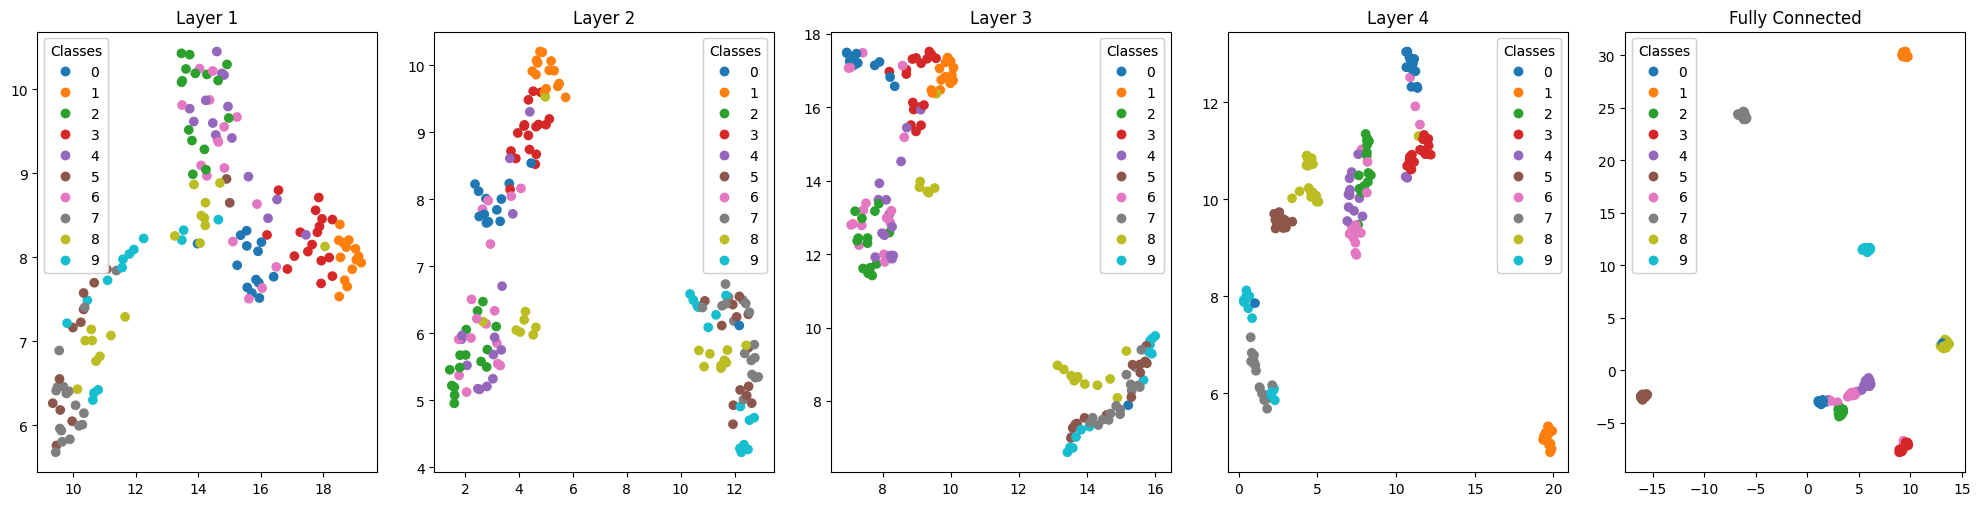

In [9]:
layers_arr = [classification_model.layer1, classification_model.layer2, classification_model.layer3, classification_model.layer4, classification_model.fc]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.tight_layout()
for i, layer in enumerate(layers_arr):
    activations = []
    hook = layer.register_forward_hook(lambda self, input, output: activations.append(output.detach()))
    for batch, labels in data_loader:
        classification_model(batch.to(device))
    hook.remove()
    activations = activations[0].view(activations[0].size(0), -1)
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
    umap_activations = umap_model.fit_transform(activations.to(cpu))
    scatter = ax[i].scatter(umap_activations[:, 0], umap_activations[:, 1], c=labels, cmap='tab10')
    legend = ax[i].legend(*scatter.legend_elements(), title='Classes')
    ax[i].add_artist(legend)
    ax[i].set_title(f"Layer {i+1}" if i < 4 else "Fully Connected")
    #ax[i].axis('off')
    #ax[i].set_aspect('equal')
    del activations
    torch.cuda.empty_cache()

In [10]:
fig.savefig("figures/umap_fashionMNIST.pdf")

c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\shafi\Desktop\M4R\mlvenv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to

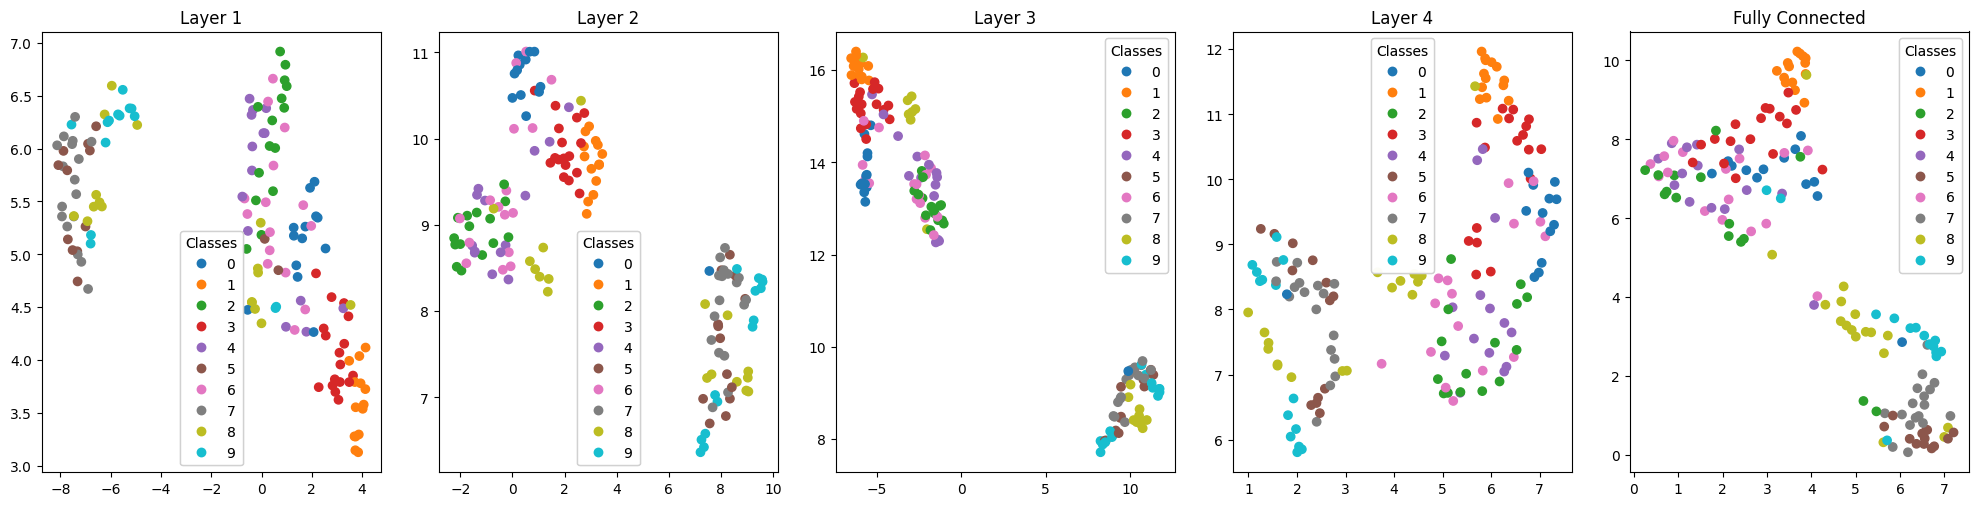

In [11]:
layers_arr2 = [classification_model2.layer1, classification_model2.layer2, classification_model2.layer3, classification_model2.layer4, classification_model2.fc]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.tight_layout()

for i, layer in enumerate(layers_arr2):
    activations = []
    hook = layer.register_forward_hook(lambda self, input, output: activations.append(output.detach()))
    for batch, labels in data_loader:
        classification_model2(batch.to(device))
    hook.remove()
    activations = activations[0].view(activations[0].size(0), -1)
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
    umap_activations = umap_model.fit_transform(activations.to(cpu))
    scatter = ax[i].scatter(umap_activations[:, 0], umap_activations[:, 1], c=labels, cmap='tab10')
    legend = ax[i].legend(*scatter.legend_elements(), title='Classes')
    ax[i].add_artist(legend)
    ax[i].set_title(f"Layer {i+1}" if i < 4 else "Fully Connected")
    #ax[i].axis('off')
    #ax[i].set_aspect('equal')
    del activations
    torch.cuda.empty_cache()

In [12]:
fig.savefig("figures/umap_fashionMNIST_1_epoch.pdf")